In [1]:
import SimpleITK as sitk
import tensorflow.python
import numpy as np
import nibabel as nib
import scipy.misc
from tqdm import tqdm_notebook, tqdm
import os
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt  # 描画用
import scipy.interpolate as interpolate
import pandas as pd

def rotate(image, angle, center):
    h, w = image.shape[:2]
    affine = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, affine, (w, h))


def load_data(cid, seg_path, vol_path):
    raw_seg = nib.load(seg_path)
    raw_vol = nib.load(vol_path)

    affine = raw_vol.affine
    raw_vol = raw_vol.get_data()
    raw_seg = raw_seg.get_data()
    return raw_vol, raw_seg


def get_slice_idx(raw_seg):
    rnumber = len(raw_seg[0, 0, :])
    imagefragarray = []
    sliceIndex = []

    # 高さ方向の腎臓、腎臓がんの範囲特定
    for x in range(rnumber):

        imagefragarray = raw_seg[:, :, x]

        if np.where(imagefragarray != 0, True, False).any():
            sliceIndex.append(x)

    return sliceIndex


In [2]:
ROOT_PATH = r"C:\Users\higuchi\Desktop\kits19\data\case_00"
cid=0
seg_path = os.path.join(ROOT_PATH + str(cid).zfill(3), "segmentation.nii.gz")
vol_path = os.path.join(ROOT_PATH + str(cid).zfill(3), "imaging.nii.gz")
raw_vol, raw_seg=load_data(cid, seg_path, vol_path)

In [6]:
Idxes=get_slice_idx(raw_seg)

In [85]:
def divide_index(sliceIndex):
    max_diff = 1
    diff = 0
    divide_idx = 0
    for x in range(1, len(sliceIndex)):
        diff = sliceIndex[x] - sliceIndex[x - 1]
        if diff >= max_diff:
            max_diff = diff
            slice1 = sliceIndex[:x]
            slice2 = sliceIndex[x:]
            divide_Idx = sliceIndex[x - 1]
    if max_diff==1:
    return slice1,slice2


In [50]:
%%time
max_area=0
max_rect=0
max_idx=0
for idx in slice1:
    slice_seg = raw_seg[:, :, idx]
    contours, hierarchy = cv2.findContours(slice_seg, 1, 2)
    max_id = np.argmax(np.array([cv2.contourArea(cnt) for cnt in contours]))
    max_countor = contours[max_id]
    
    area = cv2.contourArea(max_countor)
    rect = cv2.minAreaRect(max_countor)
    center, size, degree = rect
        # 角度から4座標に変換
    box = cv2.boxPoints(rect)
    if area>max_area:
        max_area=area
        max_rect=rect
        max_idx=idx


Wall time: 23.9 ms


In [38]:
PADDING_SIZE=20
center, size, degree = max_rect
# 角度から4座標に変換
box = cv2.boxPoints(max_rect)

# 角度が0になった場合、関心領域はどこに写像されるか取得
horizon_rect = (center, size, 0)
horizon_box = cv2.boxPoints(horizon_rect)

LX = int(horizon_box[0, 0])
RX = int(horizon_box[3, 0])
TY = int(horizon_box[0, 1])
UY = int(horizon_box[1, 1])

if LX > RX:
    LX, RX = RX, LX

if TY > UY:
    TY, UY = UY, TY

PAD_TY = TY - PADDING_SIZE if (TY - PADDING_SIZE) > 0 else 0
PAD_UY = UY + PADDING_SIZE

PAD_LX = LX - PADDING_SIZE if(LX - PADDING_SIZE) > 0 else 0
PAD_RX = RX + PADDING_SIZE



c:\users\higuchi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


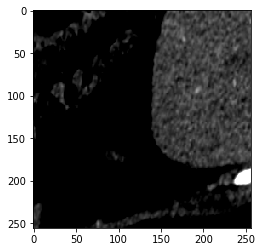

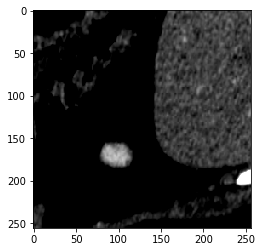

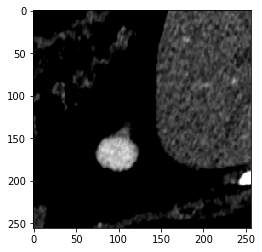

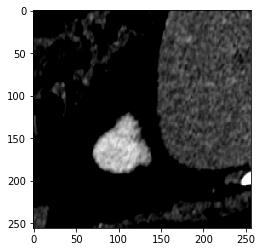

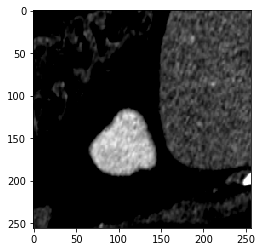

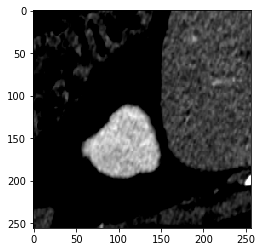

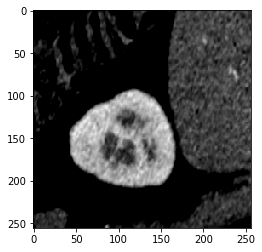

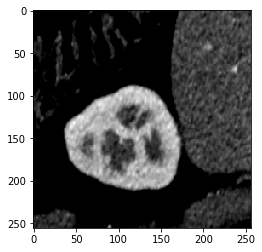

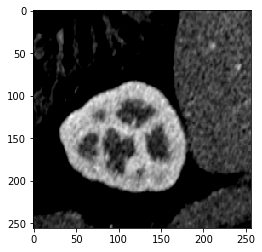

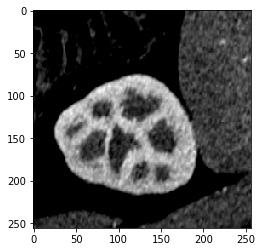

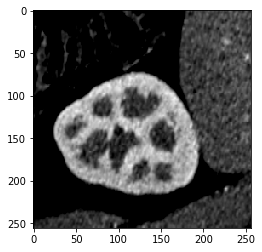

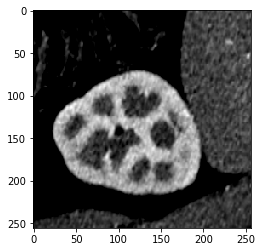

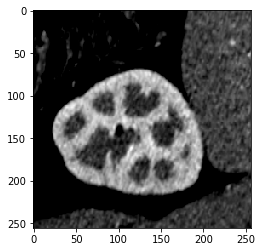

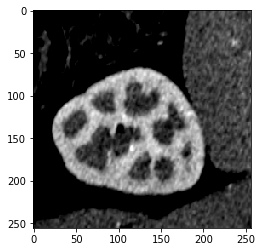

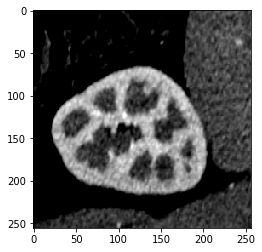

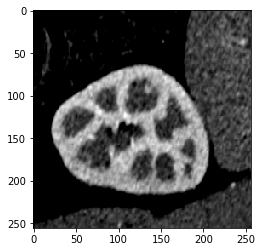

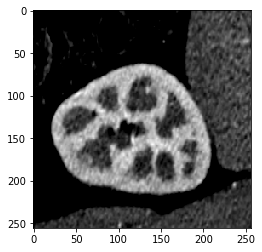

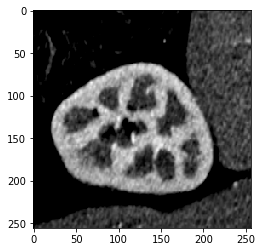

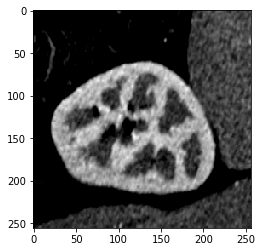

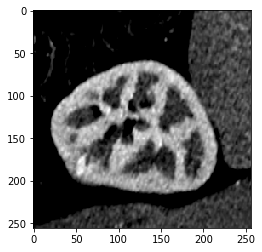

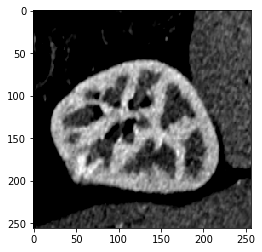

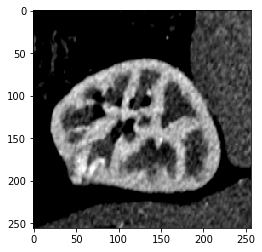

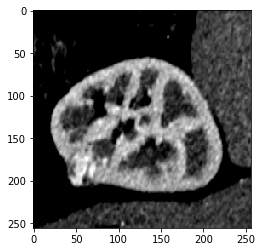

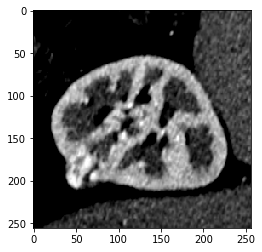

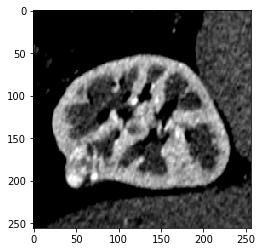

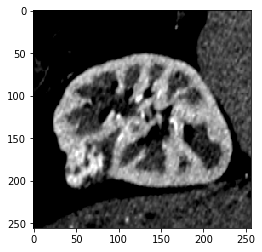

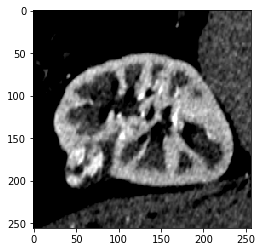

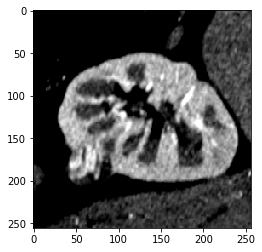

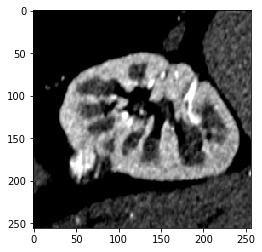

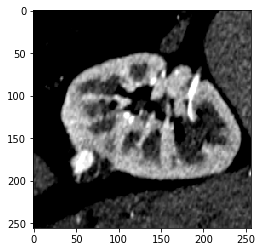

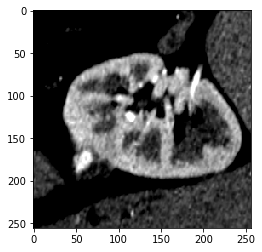

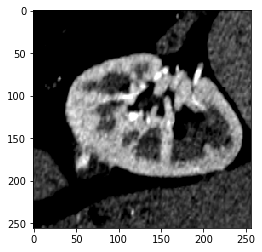

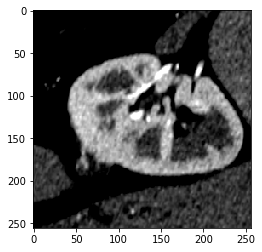

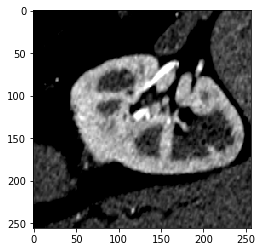

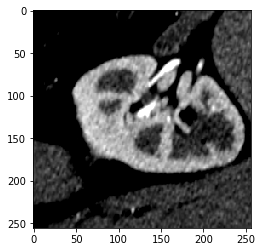

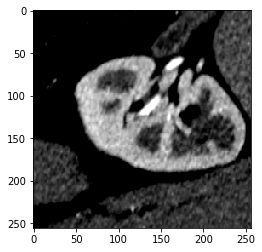

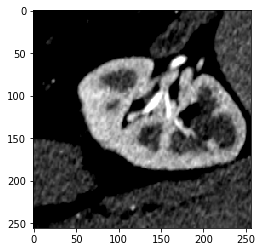

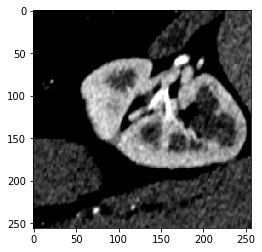

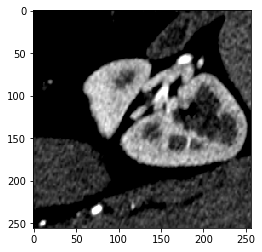

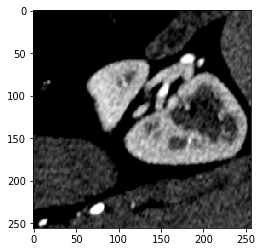

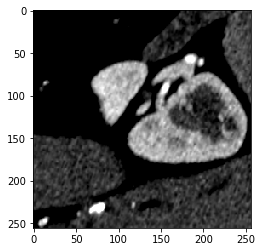

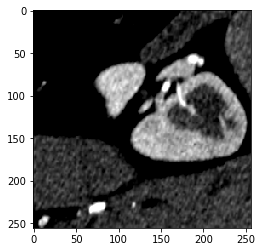

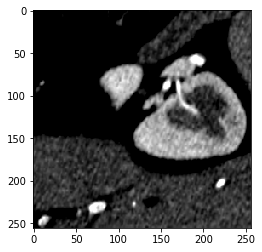

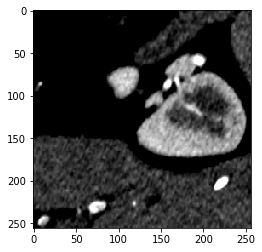

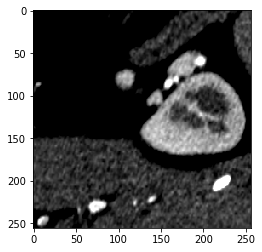

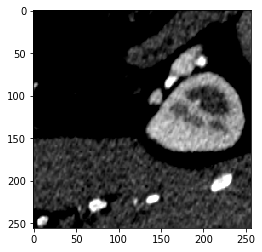

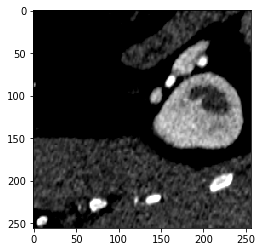

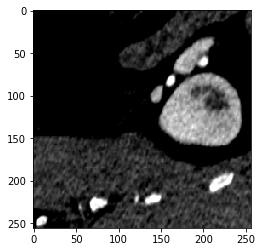

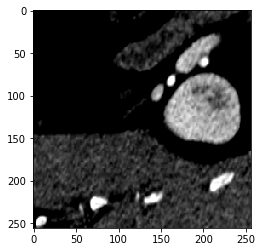

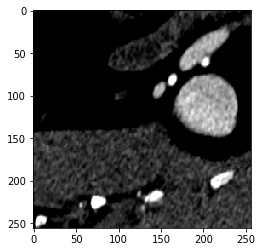

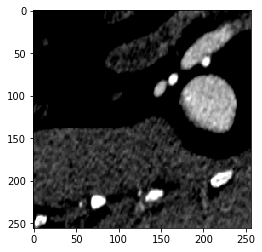

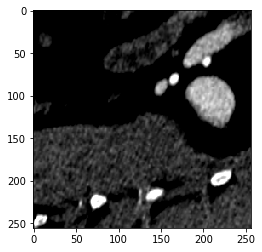

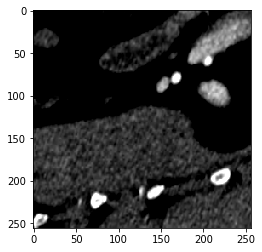

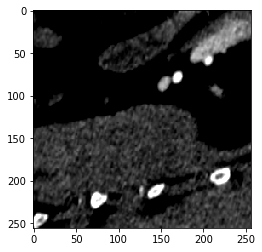

In [41]:
IM_SIZE=256
for idx in slice1:
    figure=plt.figure()
    slice_seg = raw_seg[:, :, idx]
    slice_vol = raw_vol[:, :, idx]
    
    rotate_seg_a = rotate(slice_seg, degree, center)
    clip_seg = rotate_seg_a[PAD_TY:PAD_UY, PAD_LX:PAD_RX]
    
    rotate_vol_a = rotate(slice_vol, degree, center)
    clip_vol = rotate_vol_a[PAD_TY:PAD_UY, PAD_LX:PAD_RX]
    
    seg = cv2.resize(clip_seg, dsize=(IM_SIZE, IM_SIZE), interpolation=cv2.INTER_LINEAR)
    vol=cv2.resize(clip_vol, dsize=(IM_SIZE, IM_SIZE), interpolation=cv2.INTER_LINEAR)
    seg = np.where(seg == 1, 128, seg)
    seg = np.where(seg == 2, 255, seg)
    
    
    plt.imshow(seg, 'gray', vmin = 0, vmax = 255)
    plt.imshow(vol, 'gray', vmin = 0, vmax = 255)


c:\users\higuchi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


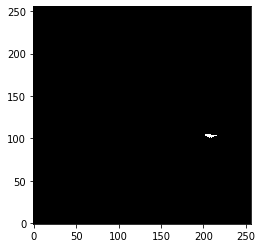

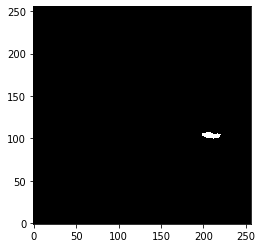

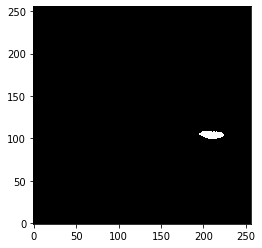

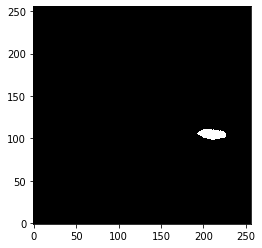

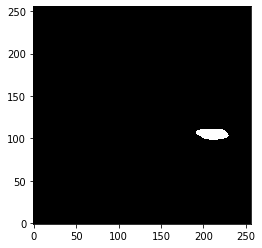

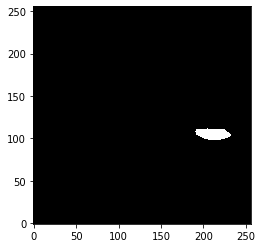

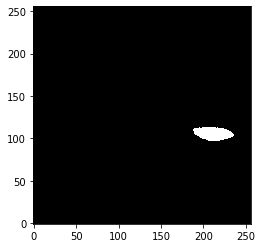

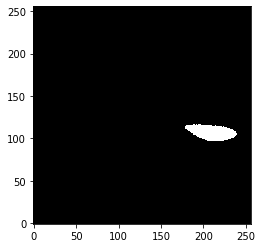

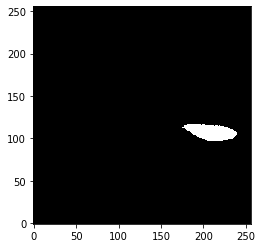

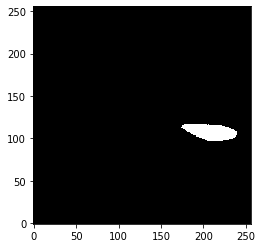

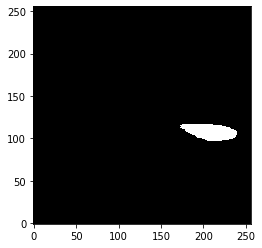

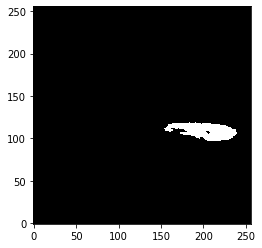

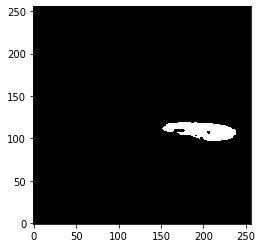

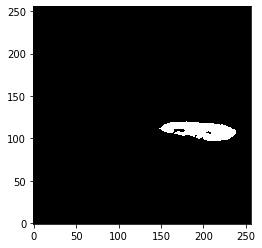

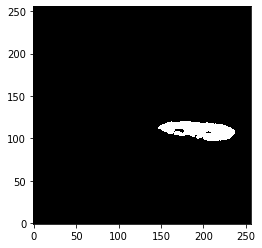

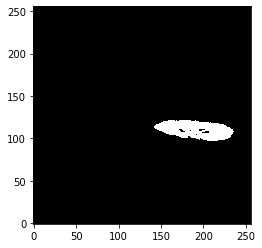

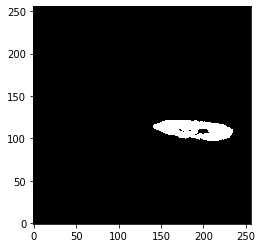

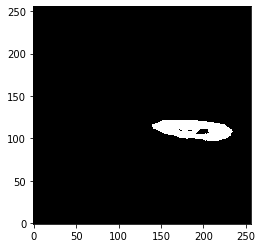

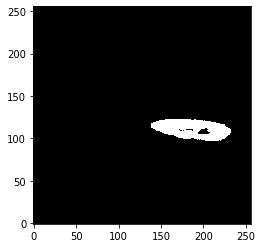

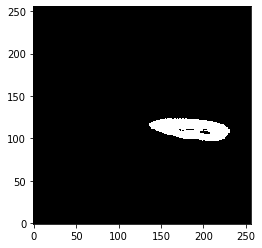

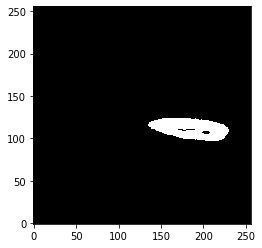

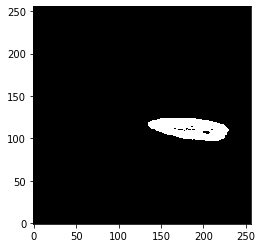

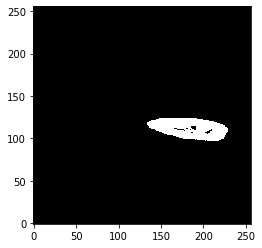

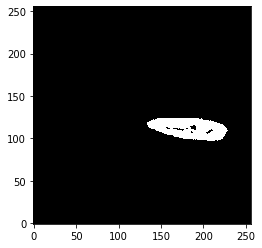

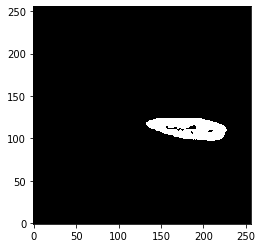

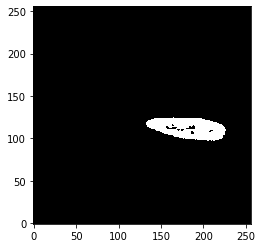

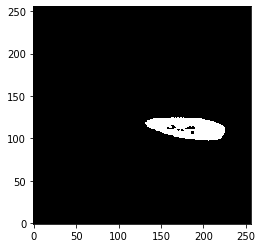

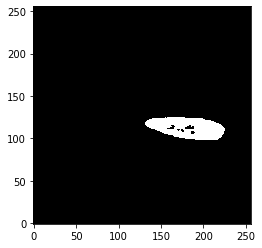

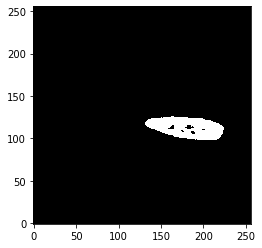

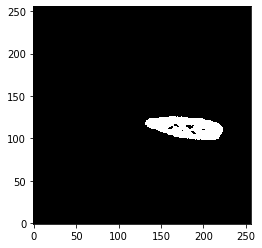

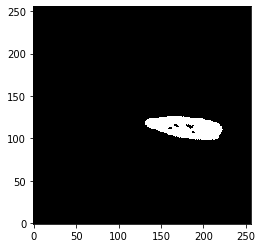

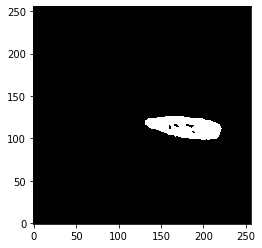

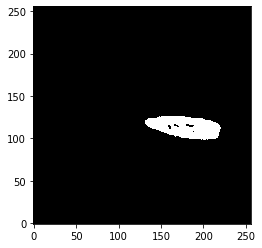

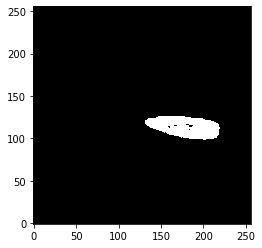

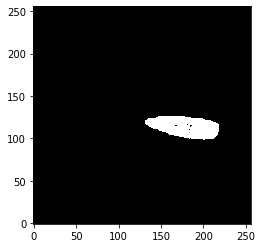

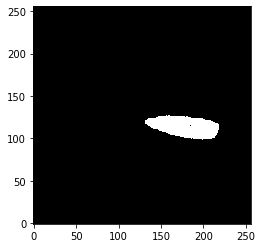

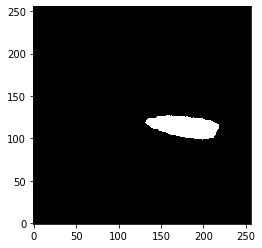

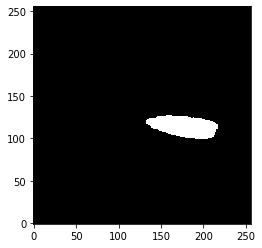

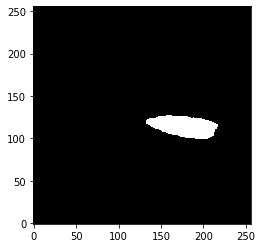

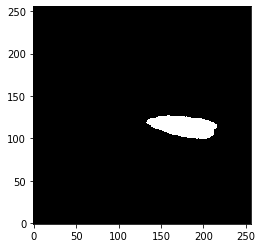

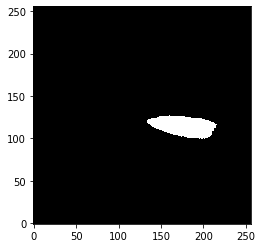

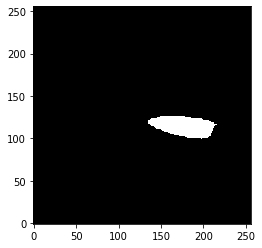

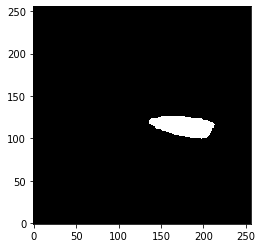

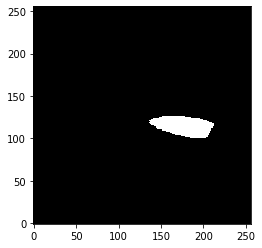

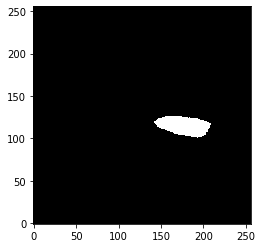

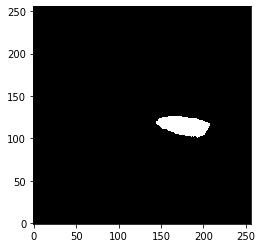

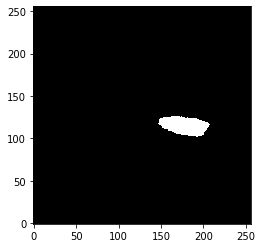

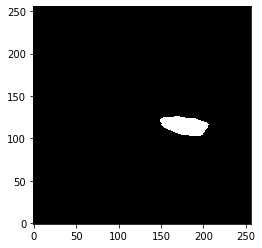

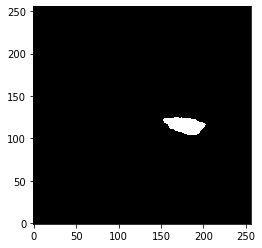

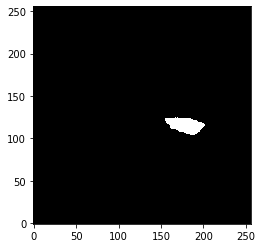

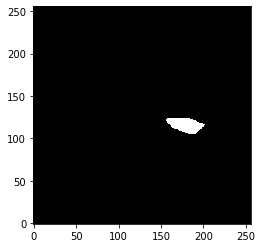

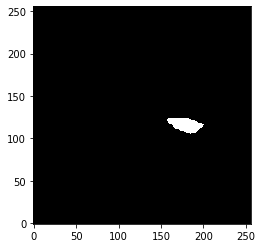

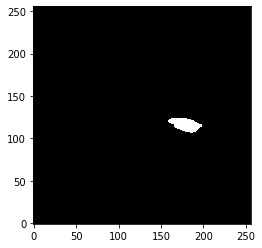

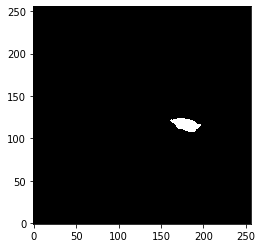

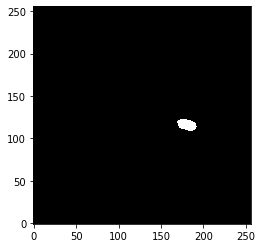

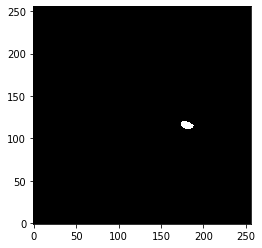

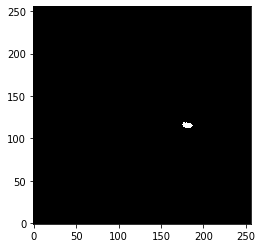

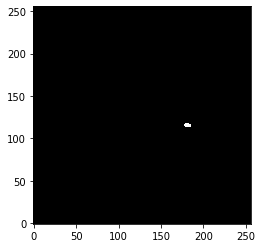

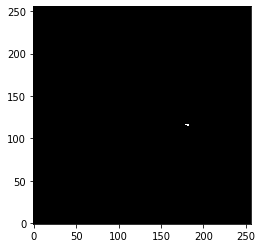

In [33]:
IM_SIZE=256
for idx in slice2:
    figure=plt.figure()
    slice_seg = raw_seg[:, :, idx]
    rotate_seg_a = rotate(slice_seg, degree, center)
    clip_seg = cv2.resize(rotate_seg_a, dsize=(IM_SIZE, IM_SIZE), interpolation=cv2.INTER_LINEAR)
    
    plt.imshow(clip_seg,cmap='Greys_r',origin='lower')

In [60]:
max_rect2

((340.6231384277344, 212.51541137695312),
 (189.15296936035156, 60.15684509277344),
 -82.87498474121094)

In [59]:
%%time
max_area2 = 0
max_rect2 = 0
max_idx2 = 0
for idx in slice2:
    slice_seg = raw_seg[:, :, idx]
    contours, hierarchy = cv2.findContours(slice_seg, 1, 2)
    max_id = np.argmax(np.array([cv2.contourArea(cnt) for cnt in contours]))
    max_countor = contours[max_id]

    area = cv2.contourArea(max_countor)
    rect = cv2.minAreaRect(max_countor)
    center, size, degree = rect
    # 角度から4座標に変換
    box = cv2.boxPoints(rect)
    if area > max_area2:
        max_area2 = area
        max_rect2 = rect
        max_idx2 = idx


Wall time: 24.9 ms


In [61]:
PADDING_SIZE=20
center, size, degree = max_rect2
# 角度から4座標に変換
box = cv2.boxPoints(max_rect2)

# 角度が0になった場合、関心領域はどこに写像されるか取得
horizon_rect = (center, size, 0)
horizon_box = cv2.boxPoints(horizon_rect)

LX = int(horizon_box[0, 0])
RX = int(horizon_box[3, 0])
TY = int(horizon_box[0, 1])
UY = int(horizon_box[1, 1])

if LX > RX:
    LX, RX = RX, LX

if TY > UY:
    TY, UY = UY, TY

PAD_TY = TY - PADDING_SIZE if (TY - PADDING_SIZE) > 0 else 0
PAD_UY = UY + PADDING_SIZE

PAD_LX = LX - PADDING_SIZE if(LX - PADDING_SIZE) > 0 else 0
PAD_RX = RX + PADDING_SIZE


c:\users\higuchi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


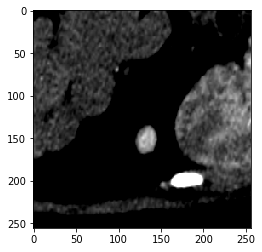

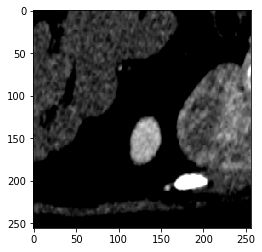

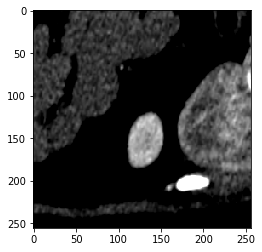

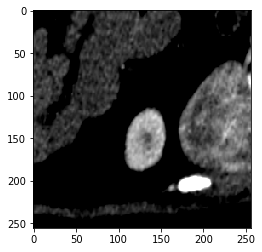

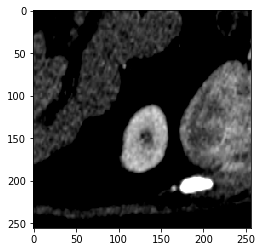

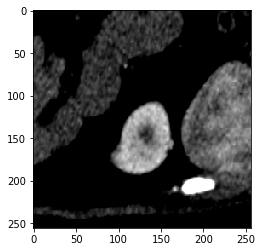

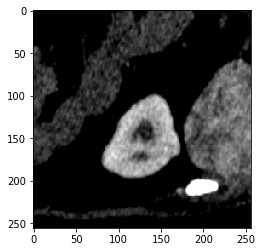

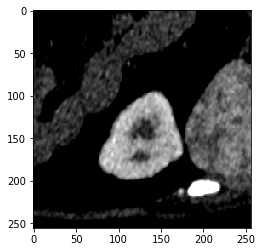

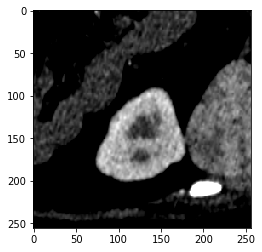

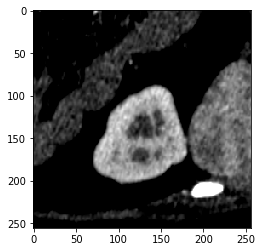

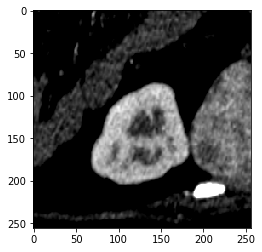

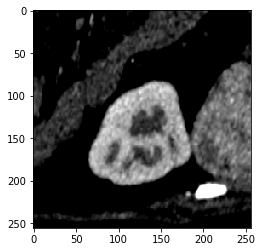

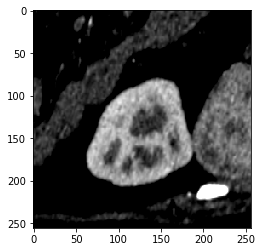

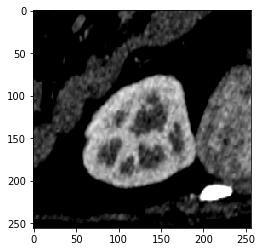

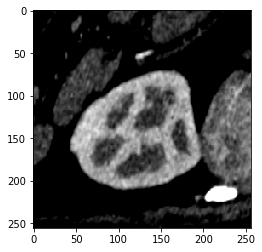

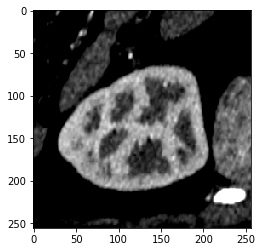

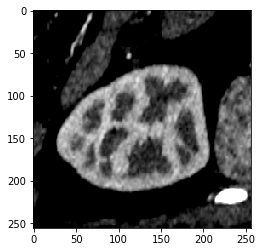

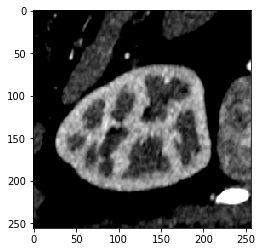

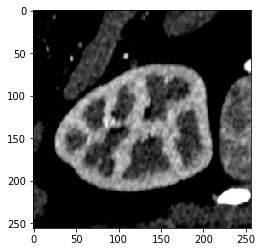

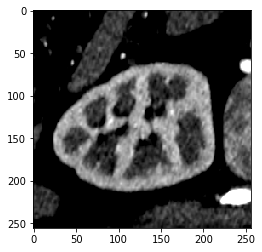

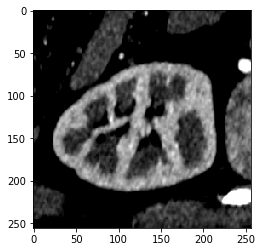

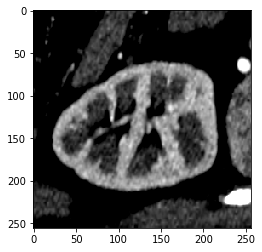

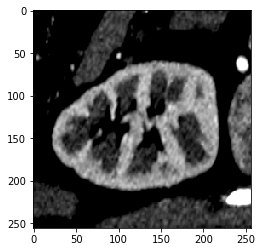

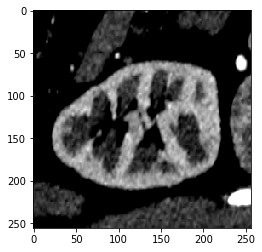

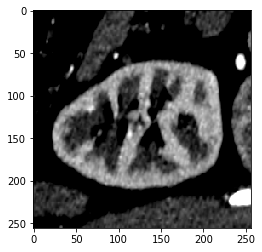

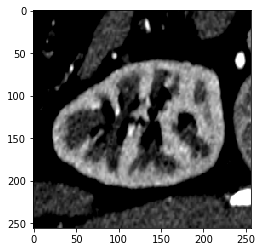

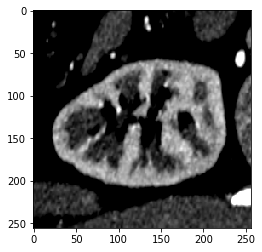

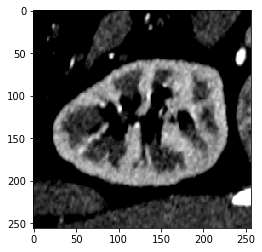

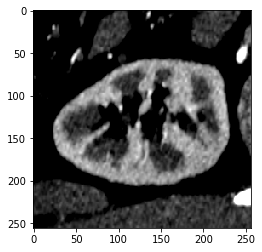

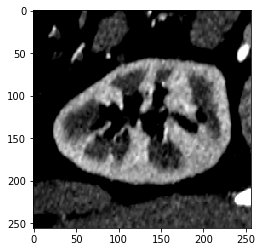

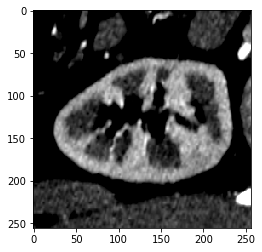

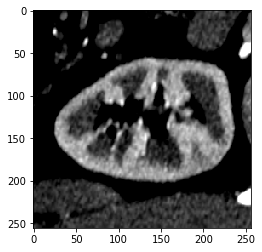

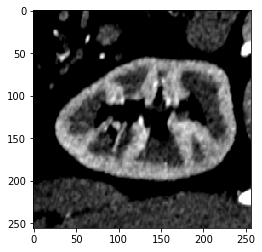

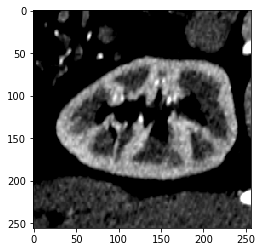

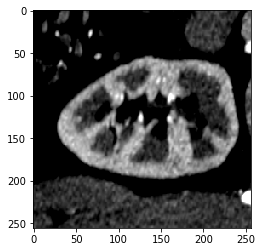

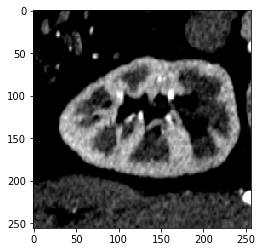

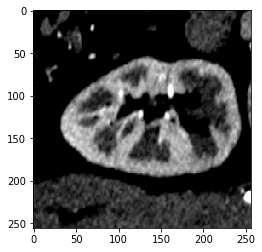

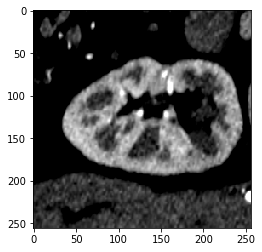

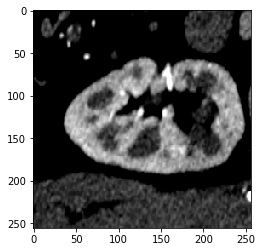

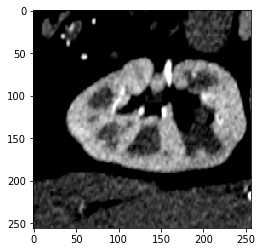

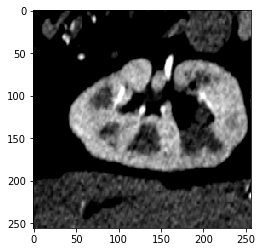

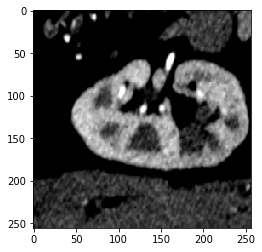

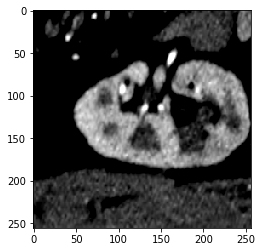

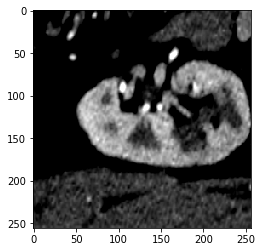

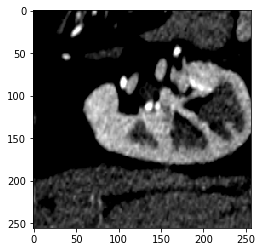

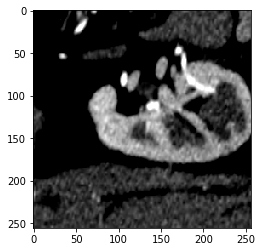

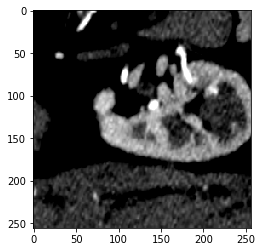

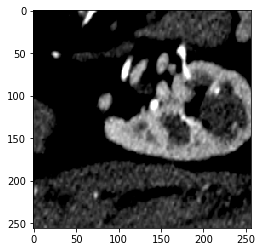

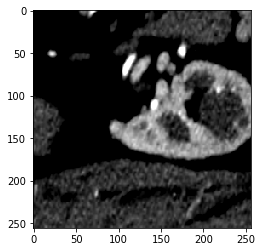

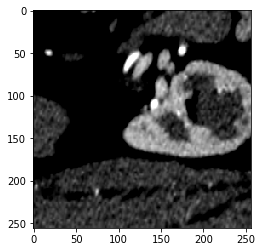

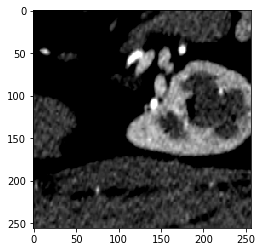

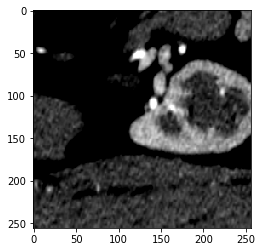

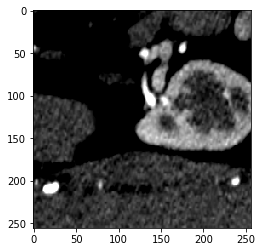

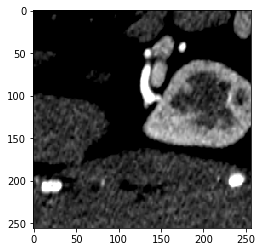

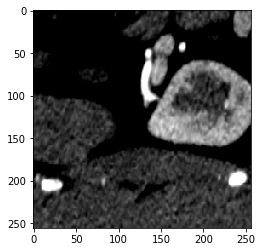

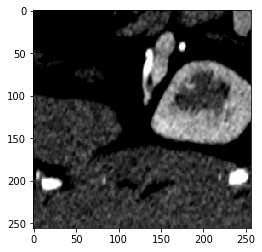

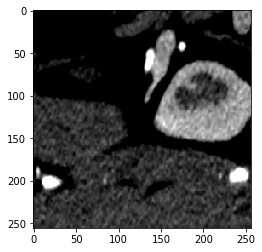

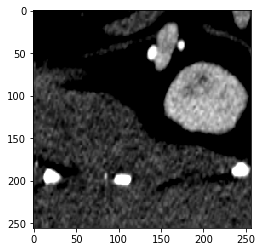

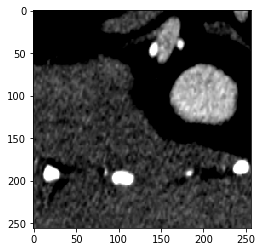

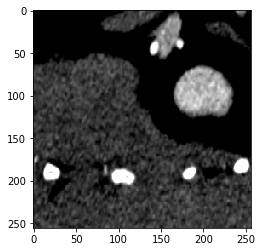

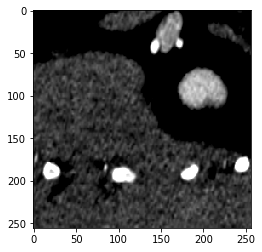

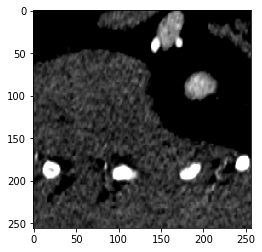

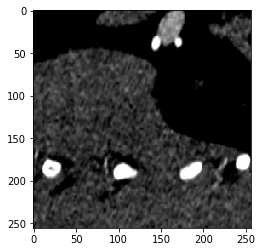

In [63]:
IM_SIZE=256
for i,idx in enumerate(reversed(slice2)):
    figure=plt.figure()
    slice_seg = raw_seg[:, :, idx]
    slice_vol = raw_vol[:, :, idx]
    
    rotate_seg_a = rotate(slice_seg, degree, center)
    clip_seg = rotate_seg_a[PAD_TY:PAD_UY, PAD_LX:PAD_RX]
    
    rotate_vol_a = rotate(slice_vol, degree, center)
    clip_vol = rotate_vol_a[PAD_TY:PAD_UY, PAD_LX:PAD_RX]
    
    seg = cv2.resize(clip_seg, dsize=(IM_SIZE, IM_SIZE), interpolation=cv2.INTER_LINEAR)
    vol=cv2.resize(clip_vol, dsize=(IM_SIZE, IM_SIZE), interpolation=cv2.INTER_LINEAR)
    seg = np.where(seg == 1, 128, seg)
    seg = np.where(seg == 2, 255, seg)
    
    
    plt.imshow(seg, 'gray', vmin = 0, vmax = 255)
    plt.imshow(vol, 'gray', vmin = 0, vmax = 255)


In [108]:
for i, idx in enumerate(reversed(range(20))):
    print(i,idx)

0 19
1 18
2 17
3 16
4 15
5 14
6 13
7 12
8 11
9 10
10 9
11 8
12 7
13 6
14 5
15 4
16 3
17 2
18 1
19 0
